In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

from datasets import load_dataset

## 1. import data

In [2]:
# Number of labels: negtive, neutral, positive
num_classes = 3

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['negtive', 'neutral', 'positive']

In [3]:
# download dataset from hungging face
dataset = load_dataset("tweet_eval", "sentiment")
dataset

Found cached dataset tweet_eval (C:/Users/Splute/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
data_train = pd.DataFrame(dataset['train'])
data_val = pd.DataFrame(dataset['validation'])
data_test = pd.DataFrame(dataset['test'])

# Balance the amount of each class
SEED = 66

num_train_per_class = 4000
# num_val_per_class = 1000
num_test_per_class = 2000
balanced_train_data = data_train.groupby('label', group_keys=False).apply(lambda x:\
        x.sample(min(len(x), num_train_per_class), random_state=SEED)).sample(frac=1, random_state=SEED)
# balanced_val_data = data_val.groupby('label', group_keys=False).apply(lambda x:\
#         x.sample(min(len(x), num_val_per_class), random_state=SEED)).sample(frac=1, random_state=SEED)
balanced_test_data = data_test.groupby('label', group_keys=False).apply(lambda x:\
        x.sample(min(len(x), num_test_per_class), random_state=SEED)).sample(frac=1, random_state=SEED)

X_train = balanced_train_data.text.tolist()
X_val = data_val.text.tolist()
X_test = balanced_test_data.text.tolist()

Y_train = balanced_train_data.label.tolist()
Y_val = data_val.label.tolist()
Y_test = balanced_test_data.label.tolist()

data = balanced_train_data.append(data_val, ignore_index=True) # ignore_index makes the index to be continued

print('size of training set: %s' % (len(balanced_train_data['text'])))
print('size of validation set: %s' % (len(data_val['text'])))
print(data.label.value_counts())

data.head(10)

size of training set: 12000
size of validation set: 2000
1    4869
2    4819
0    4312
Name: label, dtype: int64


,text,label
0,@user The picture is from Karm al-Zeitoun Mass...,1
1,"""Tony Blair to speak to Jerusalem FPA tomorrow...",0
2,3rd time seeing Kendrick and he never fails to...,2
3,"""Get ur excuses in early lol\""""@MCRisBLUE: Can...",0
4,can't remember &amp; last Friday night are lik...,1
5,"""Tomorrow I'm going to watch """"Paper Towns"""". ...",1
6,I really wish I was going to Ed Sheeran this S...,0
7,This is a good video clip of Carly Fiorina on ...,2
8,I miss Zayn I feel like he may have forgotten ...,1
9,Premier League: West Ham v Man City on Saturda...,2


## 2. Prepare input data
To input the data to our NN Model we'll need some preprocessing:
1. Tokenize our texts and count unique tokens
2. Padding: each input (sentence or text) has to be of the same lenght
3. Labels have to be converted to integeres and categorized if need

In [5]:
def clean_text(data):
    
    # 去除URL链接
    data = re.sub(r'http\S+', '', data)
    
    # 去除@提及的用户名
    data = re.sub(r'@\w+', '', data)
    
    # 去除#标签
    data = re.sub(r'#\w+', '', data)
    
    # 去除RT（转发）标识
    data = re.sub(r'RT\s+', '', data)
    
    # 去除多余的空格和换行符
    data = re.sub(r'\s+', ' ', data).strip()
    
    # tekenization using nltk / 分词
    data = word_tokenize(data)
    
    return data

In [6]:
texts = [' '.join(clean_text(text)) for text in data.text]

texts_train = [' '.join(clean_text(text)) for text in X_train] #恢复成完整的句子
texts_val = [' '.join(clean_text(text)) for text in X_val]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [7]:
print(texts_train[1])


`` Tony Blair to speak to Jerusalem FPA tomorrow ( Friday ) . Now that he is no longer Quartet rep , will he speak his mind on the Conflict ? ''


In [8]:
# Tokenization + fitting using keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train) #将每句话转换为数字，每个数字代表一个单词
sequence_val = tokenizer.texts_to_sequences(texts_val)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 20767


**Padding** -> each input has the same length

We defined maximun number of words for our texts and input size to our model has to be fixed - padding with zeros to keep the same input lenght

In [9]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_val_pad = pad_sequences(sequence_val, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,    8, 2151, 2670],
       [   0,    0,    0, ...,    1, 3206,    3],
       [   0,    0,    0, ..., 2889,    2, 9890],
       ...,
       [   0,    0,    0, ...,   46,  477, 3641],
       [   0,    0,    0, ...,   20,  207,  149],
       [   0,    0,    0, ..., 1526, 1831,    3]])

In [10]:
y_train = to_categorical(Y_train)
y_val = to_categorical(Y_val)
y_test = to_categorical(Y_test)

y_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## 2. Import pretrained word vectors

In [11]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

You can download and import any pre-trained word embeddings. I will use 300 dimentional w2v pre-trained on wikipedia articles. Download fast text english vectors: https://fasttext.cc/docs/en/english-vectors.html

In [12]:
import urllib.request
import zipfile
import os

fname = '../embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

elif os.path.isfile(fname):
    print('Founded word vectors')

Founded word vectors


In [13]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(20768, 300)

In [14]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 17047
New words found: 3720


## 3. Create LSTM Pipeline

### Embedding Layer

We will use pre-trained word vectors. We could also train our own embedding layer if we don't specify the pre-trained weights 

* **vocabulary size:** the maximum number of terms that are used to represent a text: e.g. if we set the size of the “vocabulary” to 1000 only the first thousand terms most frequent in the corpus will be considered (and the other terms will be ignored)
* **the maximum length:** of the texts (which must all be the same length)
* **size of embeddings:** basically, the more dimensions we have the more precise the semantics will be, but beyond a certain threshold we will lose the ability of the embedding to define a coherent and general enough semantic area
* **trainable:** True if you want to fine-tune them while training


In [15]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)
                        #  trainable=True)

You can change GRU to LSTM. The results will be very similar but LSTM might take longer to train.

In [16]:
# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0))) #set recurrent_dropout=0 to use cuDNN
                              # recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                # recurrent_dropout=0.2))
                recurrent_dropout=0))

model.add(Dense(num_classes, activation='softmax'))

In [17]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          6230400   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 6,561,411
Trainable params: 331,011
Non-trainable params: 6,230,400
_________________________________________________________________


## 3. Train the Model

In [18]:
batch_size = 64
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_val_pad,y_val))

Epoch 1/15
188/188 [==============================] - 20s 88ms/step - loss: 0.9560 - accuracy: 0.5207 - val_loss: 0.9566 - val_accuracy: 0.5370
Epoch 2/15
188/188 [==============================] - 16s 86ms/step - loss: 0.8181 - accuracy: 0.6256 - val_loss: 0.8335 - val_accuracy: 0.5920
Epoch 3/15
188/188 [==============================] - 16s 87ms/step - loss: 0.7851 - accuracy: 0.6430 - val_loss: 0.8736 - val_accuracy: 0.5885
Epoch 4/15
188/188 [==============================] - 16s 87ms/step - loss: 0.7631 - accuracy: 0.6602 - val_loss: 0.8576 - val_accuracy: 0.5985
Epoch 5/15
188/188 [==============================] - 16s 87ms/step - loss: 0.7515 - accuracy: 0.6628 - val_loss: 0.8262 - val_accuracy: 0.6130
Epoch 6/15
188/188 [==============================] - 16s 87ms/step - loss: 0.7313 - accuracy: 0.6737 - val_loss: 0.8247 - val_accuracy: 0.6075
Epoch 7/15
188/188 [==============================] - 17s 89ms/step - loss: 0.7174 - accuracy: 0.6820 - val_loss: 0.8751 - val_accuracy:

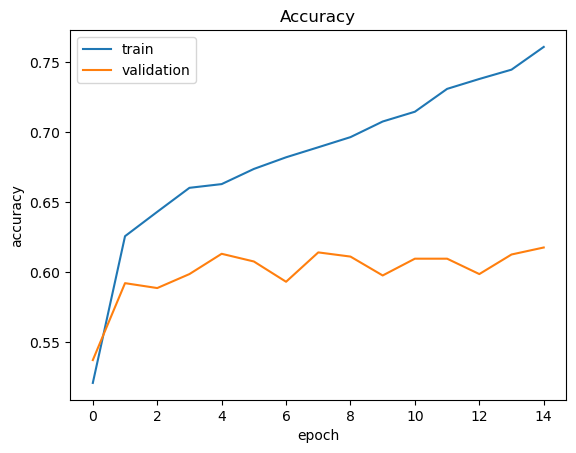

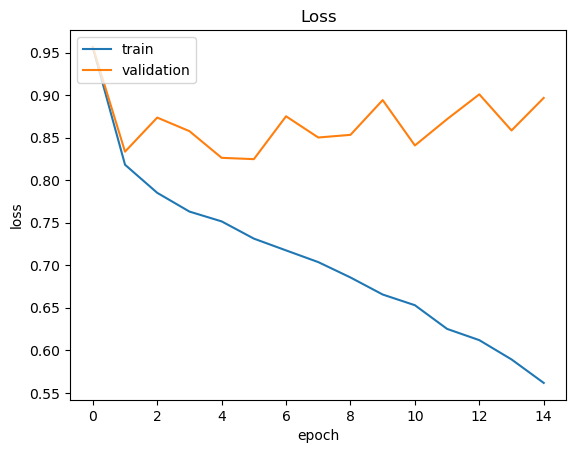

In [19]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. Evaluation

In [20]:
predictions = model.predict(X_test_pad)
print(predictions[0])

[0.8945523  0.05675348 0.04869427]


In [21]:
predictions = np.argmax(predictions, axis=1)
print(predictions)


[0 0 2 ... 0 0 0]


In [22]:
print("Accuracy: {:.2f}%".format(accuracy_score(Y_test, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(Y_test, predictions, average='weighted') * 100))

Accuracy: 62.00%

F1 Score: 62.07


In [23]:
print('Message: {}\nPredicted: {}'.format(X_test[5], predictions[5]))

Message: To those who are so excited about Trump not taking the 400K salary -Let me post this for you, again:
Predicted: 2


In [50]:
# creates a HDF5 file 'my_model.h5'
model.save('../models/biLSTM_tweet.h5')

In [ ]:
# reload the model
from keras.models import load_model
predictor = load_model('models/biLSTM_w2v.h5')

## The End